In [15]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-ov82wiid
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ov82wiid
  Created wheel for albumentations: filename=albumentations-0.4.5-py3-none-any.whl size=65101 sha256=7a497e265cb9a7c728601eef62503dbfc5b716f7eeeb80eb5ea08e905f344dbe
  Stored in directory: /tmp/pip-ephem-wheel-cache-melnmrqx/wheels/71/47/a1/9fb38b59d1a7a073dee774966fd5e64fe345dd1f55a18fb7c7
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [16]:
!pip install torchsummary

In [17]:
cp -avr /kaggle/input/vision /kaggle/working/

'/kaggle/input/vision/models/__init__.py' -> '/kaggle/working/vision/models/__init__.py'
'/kaggle/input/vision/models/cifar10.py' -> '/kaggle/working/vision/models/cifar10.py'
'/kaggle/input/vision/models/mnistmodel.py' -> '/kaggle/working/vision/models/mnistmodel.py'
'/kaggle/input/vision/models/resnet.py' -> '/kaggle/working/vision/models/resnet.py'
'/kaggle/input/vision/models/customeResNet.py' -> '/kaggle/working/vision/models/customeResNet.py'
'/kaggle/input/vision/_init__.py' -> '/kaggle/working/vision/_init__.py'
'/kaggle/input/vision/gradcam.py' -> '/kaggle/working/vision/gradcam.py'
'/kaggle/input/vision/train_test_model.py' -> '/kaggle/working/vision/train_test_model.py'
'/kaggle/input/vision/dataloaders.py' -> '/kaggle/working/vision/dataloaders.py'
'/kaggle/input/vision/Tiny_Imagenet_200.py' -> '/kaggle/working/vision/Tiny_Imagenet_200.py'
'/kaggle/input/vision/lr_range_test.py' -> '/kaggle/working/vision/lr_range_test.py'
'/kaggle/input/vision/plot_grad.py' -> '/kaggle/wor

In [18]:
cd /kaggle/working

/kaggle/working


## Necessary Imports

In [19]:
import numpy as np

import torch
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import ReduceLROnPlateau


from vision import dataloaders
from vision.utils import Helper
from vision.models.resnet import ResNet18
from vision.models.customeResNet import CustomModel
from vision.imagetransforms import TorchTransforms,  album_train_transforms, album_test_transforms, trainset_albumentations, testset_albumentations
from vision.train_test_model import RunModel
from vision.lr_finder import LRFinder
from vision import plot_grad
from vision import train_test_model
from vision import train_test_
from vision.lr_range_test import RangeTest
from vision.Tiny_Imagenet_200 import TinyImageNetDataSet, download_images


import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
num_classes = 200
Net = ResNet18(num_classes)
helper = Helper()

### Model Summary

In [21]:
size =  (3, 64, 64)
helper.model_summary(Net, size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

### Download and split dataset

In [22]:
download_images()

Images already downloaded...


In [23]:
ls

__notebook_source__.ipynb  tiny-imagenet-200/  vision/


In [24]:
imagenet_path=  r"/kaggle/working/tiny-imagenet-200"
test_size = 0.30

train_dataset_x, test_dataset_x, train_y, test_y  = TinyImageNetDataSet(imagenet_path, test_size)

## Transforms and DataLoaders

In [25]:
train_transforms = trainset_albumentations(train_dataset_x, train_y)
test_transforms = testset_albumentations(test_dataset_x, test_y)
loader = dataloaders.Loader(train_transforms, test_transforms, 'custom', batch_size=64)

train_dataloader  = loader.dataloader_train()
test_dataloader = loader.dataloader_test()
gradcam_dataloader = loader.dataloader_gradcam()

In [26]:
len(train_transforms), len(test_transforms)

(77000, 33000)

### LR Range Test

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


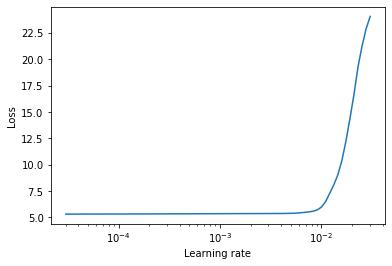

In [63]:
L2 = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr=1e-5,momentum=0.9, weight_decay=L2)#, nesterov=True)
lr_finder = LRFinder(Net, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dataloader, val_loader=test_dataloader, end_lr=0.1, num_iter=100, step_mode="exp")
lr_finder.plot() 
lr_finder.reset()

In [64]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
Best_lr=lr[loss.index(min(loss))]

In [65]:
Best_lr

1.202264434617413e-05

### Model training

In [27]:
epochs = 50
L2 = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr=1e-2,momentum=0.9)#, weight_decay=L2)#, nesterov=True)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience = 2,min_lr=1e-5)

In [28]:
run = RunModel(Net, train_dataloader, test_dataloader, optimizer, scheduler, epochs, criterion) 
run.train_test()

  0%|          | 0/1204 [00:00<?, ?it/s]

Epoch 1:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0684, Accuracy: 2645/33000 (8.02%)
Epoch 2:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0582, Accuracy: 5342/33000 (16.19%)
Epoch 3:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0515, Accuracy: 7919/33000 (24.00%)
Epoch 4:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0480, Accuracy: 9275/33000 (28.11%)
Epoch 5:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0449, Accuracy: 10657/33000 (32.29%)
Epoch 6:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0424, Accuracy: 11619/33000 (35.21%)
Epoch 7:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0411, Accuracy: 12354/33000 (37.44%)
Epoch 8:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0394, Accuracy: 13142/33000 (39.82%)
Epoch 9:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0386, Accuracy: 13542/33000 (41.04%)
Epoch 10:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0377, Accuracy: 14034/33000 (42.53%)
Epoch 11:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0363, Accuracy: 14697/33000 (44.54%)
Epoch 12:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0363, Accuracy: 14758/33000 (44.72%)
Epoch 13:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0367, Accuracy: 14877/33000 (45.08%)
Epoch 14:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0364, Accuracy: 15247/33000 (46.20%)
Epoch 15:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0357, Accuracy: 15430/33000 (46.76%)
Epoch 16:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0297, Accuracy: 17848/33000 (54.08%)
Epoch 17:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 17992/33000 (54.52%)
Epoch 18:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0294, Accuracy: 18034/33000 (54.65%)
Epoch 19:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0294, Accuracy: 18070/33000 (54.76%)
Epoch 20:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0294, Accuracy: 18070/33000 (54.76%)
Epoch 21:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0294, Accuracy: 18079/33000 (54.78%)
Epoch 22:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18053/33000 (54.71%)
Epoch 23:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0296, Accuracy: 18067/33000 (54.75%)
Epoch 24:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0297, Accuracy: 18080/33000 (54.79%)
Epoch 25:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0298, Accuracy: 18057/33000 (54.72%)
Epoch 26:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0299, Accuracy: 18083/33000 (54.80%)
Epoch 27:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0299, Accuracy: 18005/33000 (54.56%)
Epoch 28:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0300, Accuracy: 18046/33000 (54.68%)
Epoch 29:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0296, Accuracy: 18235/33000 (55.26%)
Epoch 30:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0296, Accuracy: 18198/33000 (55.15%)
Epoch 31:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0296, Accuracy: 18209/33000 (55.18%)
Epoch 32:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18213/33000 (55.19%)
Epoch 33:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18233/33000 (55.25%)
Epoch 34:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18223/33000 (55.22%)
Epoch 35:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18214/33000 (55.19%)
Epoch 36:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18224/33000 (55.22%)
Epoch 37:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18253/33000 (55.31%)
Epoch 38:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18206/33000 (55.17%)
Epoch 39:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18210/33000 (55.18%)
Epoch 40:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18221/33000 (55.22%)
Epoch 41:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18216/33000 (55.20%)
Epoch 42:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0296, Accuracy: 18208/33000 (55.18%)
Epoch 43:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18197/33000 (55.14%)
Epoch 44:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18230/33000 (55.24%)
Epoch 45:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18240/33000 (55.27%)
Epoch 46:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18232/33000 (55.25%)
Epoch 47:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18210/33000 (55.18%)
Epoch 48:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18225/33000 (55.23%)
Epoch 49:
---------


  0%|          | 0/1204 [00:00<?, ?it/s]

Testing: Average loss: 0.0295, Accuracy: 18229/33000 (55.24%)
Epoch 50:
---------


 Loss=0.08278191089630127 Train Accuracy=80.23%: 100%|██████████| 1204/1204 [02:42<00:00,  7.40it/s]


Testing: Average loss: 0.0295, Accuracy: 18198/33000 (55.15%)


## Train-Test Accuracy and Loss Graphs

In [29]:
train_acc, test_acc = run.get_accuracies()
train_losses, test_losses = run.get_losses()

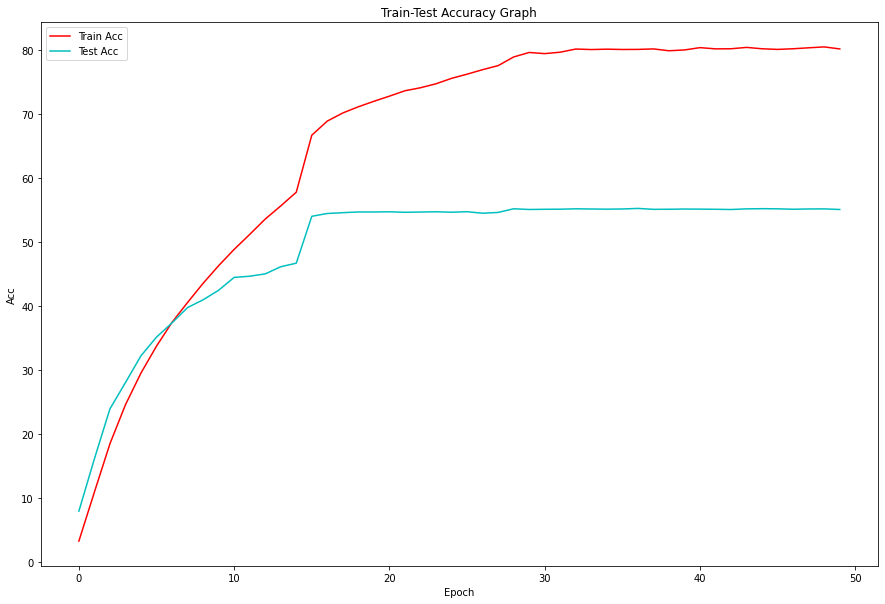

In [30]:
helper.plot_acc_graph(train_acc, test_acc, epochs)

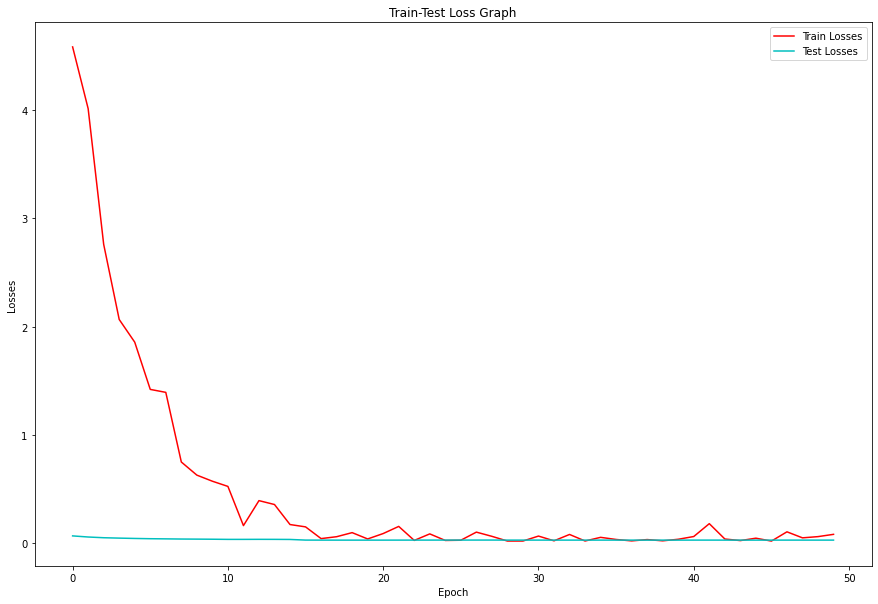

In [31]:
helper.plot_loss_graph(train_losses, test_losses, epochs)